In [46]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm
import matplotlib.pyplot as plt
import pingouin as pg


from tqdm.auto import tqdm

plt.style.use('ggplot')

In [47]:
# скачаем данные, используя разделитель ;
a_b_test = pd.read_csv('hw_bootstrap.csv', sep=';')

# Предобработка

In [48]:
# посмотрим на таблицу
a_b_test.head(2)

,Unnamed: 0,value,experimentVariant
0,1,"10,3804953740268",Control
1,2,"9,54686666784264",Control


In [49]:
# можно увидеть: 1000 строк, пропущенных значений нет, в столбце value значения object
a_b_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         1000 non-null   int64 
 1   value              1000 non-null   object
 2   experimentVariant  1000 non-null   object
dtypes: int64(1), object(2)
memory usage: 23.6+ KB


In [50]:
# посмотрим на объем групп, он равный
a_b_test.experimentVariant.value_counts()

Control      500
Treatment    500
Name: experimentVariant, dtype: int64

In [51]:
# уберем не нужную колонку
a_b_test = a_b_test.drop('Unnamed: 0', axis=1)

In [52]:
# чтобы перевести данные по колонке value в нужный тип(float), надо заменить запятую на точку
a_b_test['value'] = a_b_test.value.apply(lambda x: x.replace(',', '.'))

In [53]:
# меняем тип данных в колонке
a_b_test = a_b_test.astype({'value': 'float'})

In [54]:
# проверяем как получилось
a_b_test.dtypes

value                float64
experimentVariant     object
dtype: object

In [55]:
# посмотрев на данные, можно сделать предположение, что есть большие выбросы max=3000 хотя средняя 18,6 и 75% только 10,6
a_b_test.describe()

,value
count,1000.000000
mean,18.674183
std,132.135045
min,6.436541
25%,9.414051
50%,10.020862
75%,10.669292
max,3000.000000


In [56]:
# для удобства запишим данные по каждой группе в отдельные переменные, что будет требоваться для некоторых тестов
control_group = a_b_test.query('experimentVariant == "Control"').value
test_group = a_b_test.query('experimentVariant == "Treatment"').value

# Найдем p_value тремя способами: t-тест, U-тест Mann-Whitney и бутстрап

In [57]:
# для начала проверим наши выборки на нормальность
# видно, что в Control группе распределение нормальное, а в Treatment - нет
pg.normality(data=a_b_test, group='experimentVariant', dv='value', method='normaltest')

,W,pval,normal
Control,2.943459,2.295282e-01,True
Treatment,929.515767,1.439514e-202,False


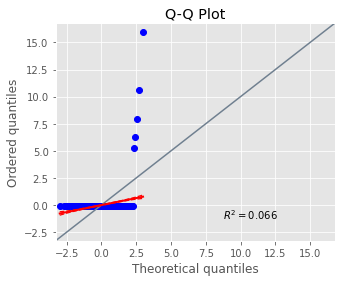

In [73]:
# посмотрим на распределение значений при помощи qqplot, видно, что присутствуют значительные выбросы
pg.qqplot(test_group)

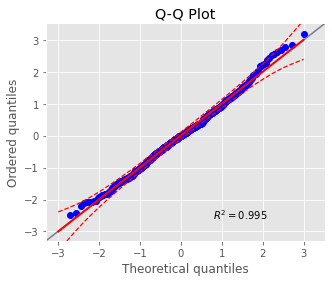

In [74]:
# а вот для сравнение нормальное распределение, видно что, хоть и есть не большые отклонения, но идет в доль линии
pg.qqplot(control_group)

In [60]:
# проверим на однородность дисперсий
# результат отрицательный, дисперсии не однородны
pg.homoscedasticity(data=a_b_test, group='experimentVariant', dv='value')

,W,pval,equal_var
levene,4.297837,0.038417,False


In [61]:
# сделаем ttest, хоть и требует нормального распределения, можно допускать некоторые базовые нарушения
# но из-за больших выбросов, он может не правильно работать
# p-val меньше 0,05, значит мы получили статистически значимый результат и принимаем альтернативную гипотезу
pg.ttest(control_group, test_group)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-2.072902,998,two-sided,0.038438,"[-33.67, -0.92]",0.131102,0.586,0.544197


In [62]:
# так как дисперсии не равные, лучше в таких ситуациях использовать тест с поправкой на это. Тест Геймса Хоувелла в студию
# можно заметить, что результат почти одинаковый
pg.pairwise_gameshowell(data=a_b_test, dv="value", between="experimentVariant")

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Control,Treatment,10.026867,27.321499,-17.294633,8.343198,-2.072902,499.027505,0.038693,-0.131003


In [63]:
# чтобы провести bootstrap, нам нужна функция для bootstrap
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {
#         "boot_data": boot_data, (мешает, слишком многот значений на выходе)
            "quants": quants, 
            "p_value": p_value}

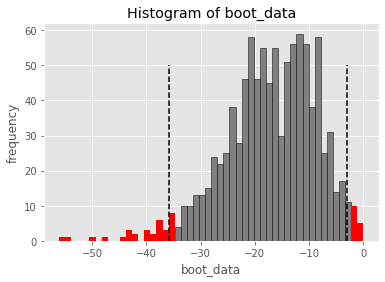

{'quants':                0
 0.025 -35.776337
 0.975  -3.085864,
 'p_value': 0.04188232789802164}

In [64]:
# передадим в функцию данные(value) по Control и Treatment группе
# получаем вывод, что средние значимо отличаются, так как доверительный интервал не включает 0
# следовательно разница между выборками присутствует
# так же еще p_value < 0,05, следовательно получили статистически значимый результат
get_bootstrap(control_group, test_group)

In [65]:
# теперь воспользуемся непараметрическим тестом (U-тест Mann-Whitney)
# p-val гораздо выше 0,05, значит принимаем нулевую гипотезу о том, что нет различий в выборке
pg.mwu(control_group, test_group)

,U-val,alternative,p-val,RBC,CLES
MWU,124189.5,two-sided,0.859215,0.006484,0.496758


# Найдем p_value теми же тремя способами, но только откинем выбросы в тестовой (Treatment) группе. Для сравнения результатов, как влияют выбросы

In [66]:
# сначала создадим новую таблицу без выбросов, отбросим значения больше 20
# таки образом отсеилось 5 значений, как и было видно по графику qqplot, что их только 5
a_b_test_without_ejections = a_b_test.query('value < 20')

In [67]:
# запишем в переменную значения только по группе Treatment
# так как в контрольной группе изменений не было, не будем перезаписывать переменную
test_without_ejections = a_b_test_without_ejections.query('experimentVariant == "Treatment"').value

In [68]:
# тест на нормальность уже показывает, что оба распределения нормальны
pg.normality(data=a_b_test_without_ejections, group='experimentVariant', dv='value', method='normaltest')

,W,pval,normal
Control,2.943459,0.229528,True
Treatment,3.426451,0.180283,True


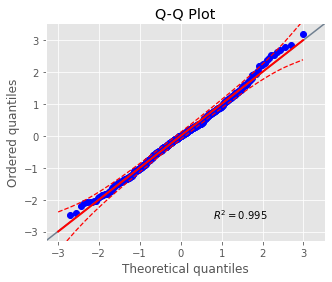

In [75]:
# вот как выглядит распределение по тестовой группе, когда убрали выбросы
# видим небольшие отклонения, но распределение нормальное
pg.qqplot(test_without_ejections)

In [69]:
# проверим на однородность дисперсий
# вот уже и дисперсии однородны
pg.homoscedasticity(data=a_b_test_without_ejections, group='experimentVariant', dv='value')

,W,pval,equal_var
levene,0.004298,0.947742,True


In [70]:
# делаем t-test и уже значение p-val близкое к 1
# что говорит о том, что выборки значительно не отличаются и не можем отклонить нулевую гипотезу
pg.ttest(control_group, test_without_ejections)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.082992,992.92318,two-sided,0.933875,"[-0.12, 0.13]",0.005262,0.071,0.050788


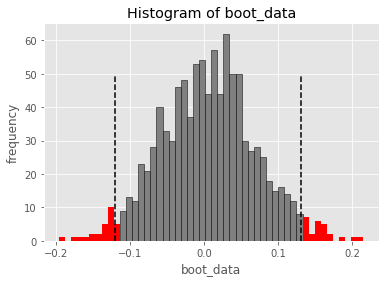

{'quants':               0
 0.025 -0.120234
 0.975  0.131093,
 'p_value': 0.9306498181892231}

In [71]:
# передадим в функцию данные(value) по Control и Treatment группе
# получаем вывод, что средние значимо не отличаются, так как доверительный интервал включает 0 (прям по середине)
# следовательно разницы между выборками нет
# p_value > 0,05, следовательно принимаем нулевую гипотезу (о равенстве средних в выборке)
get_bootstrap(control_group, test_without_ejections)

In [72]:
# теперь воспользуемся непараметрическим тестом (U-тест Mann-Whitney)
# p-val гораздо выше 0,05, значит отклонить нулевую гипотезу мы не можем
pg.mwu(control_group, test_without_ejections)

,U-val,alternative,p-val,RBC,CLES
MWU,124189.5,two-sided,0.922839,-0.003552,0.501776


# Вывод:

Сравнили не только 3 теста по проверки равности выборок, но еще и увидели то, как влияют выбросы на результаты этих тестов.

При значительных выбросах, t-test слабеет и не дает точные результаты, т.к. они все же влияют не среднюю(p-value=0.04). А без выбросов, t-test уже показал p-value очень близкое к единице(0.93), что говорит о равности выборок.
Тоже касается и бутстрапа, он не поможет при плохом распределении, чтобы оценить среднее, потому что среднии все равно могут сместиться из-за выбросов(p-value=0.04). А без выбросов результат почти такой же, как и t-test (p-value=0.99).
А вот уже непараметрический тест U-тест Mann-Whitney показал, что устойчив к выбросам, так с выбросами значение p-value было равно 0.86, а без них стало немного больше - 0.92.

В итоге можно сделать вывод, что значительные выбросы влияют на t-test и бутстрап, тогда как непараметрический тест U-тест Mann-Whitney устоячив к ним. Следовательно, использовать один из этих тестов нужно в зависимости от данных, которые имеем и их формы распределения(нормальное или не нормальное). Хотя использовать t-test и бутстрап при не нормальном распределении можно, если выбросы не значительны. Но в нашем задании, лучше использовать непараметрический тест U-тест Mann-Whitney, так как данные имеют значительные выбросы.